# ---------------------------DATA EXPLORATION & WRANGLING------------------------

In [1]:
# All NECESSARY IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [20]:
"""
A set of helper functions

"""
def filter_parcels(df, random_state=0):
    """filter the merged train and properties datasets to only include one record per parcel.
    
    Intended only for use on the training data for building the model

    Keyword arguments:
    df -- the result of `merge_dataset`
    random_state -- the random seed to be passed to the `pandas.DataFrame.sample()` method
    
    Returns:
    a pandas dataframe
    """
 
    count_parcelid = df.groupby('parcelid').size()
    more_than_one_parcelid = df[df.parcelid.isin(count_parcelid[count_parcelid > 1].index)]
    one_parcelid = df[df.parcelid.isin(count_parcelid[count_parcelid == 1].index)]
    #print(more_than_one_parcelid.parcelid.nunique())

    reduced_df = more_than_one_parcelid.groupby('parcelid').first().reset_index()
    reduced_df = pd.concat([one_parcelid, reduced_df])
    
    return reduced_df

In [21]:
# Reading the merged data

df = pd.read_csv('/Users/sonalichaudhari/Desktop/Projects/Zillow/data/train_merged_data.csv',low_memory=False)
print(df.shape)
df.head()

(90275, 60)


,parcelid,logerror,transactiondate,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,...,numberofstories,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock
0,11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
1,14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
2,12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
3,12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
4,14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


### Checking for duplicate parcelid

In [23]:
#Checking if duplicate parcelid exists
df.parcelid.nunique() == len(df.parcelid)

False

In [39]:
count_parcelid = df.groupby('parcelid').size()
more_than_one_parcelid = df[df.parcelid.isin(count_parcelid[count_parcelid > 1].index)]
one_parcelid = df[df.parcelid.isin(count_parcelid[count_parcelid == 1].index)]
print("Number of parcelids having more than one records: ")
print(more_than_one_parcelid.parcelid.nunique())

Number of parcelids having more than one records: 
124


It appears that some homes were sold twice during the period that the training data was captured. We have a few options here, and it's just as imporatant to discuss the tradeoffs between them as choosing the "right" one (and there usually is no "right" one).

We know that we don't want the model to overweight properties that have more than one record because we want it to perform well on our holdout set. On the other hand, there is valuable information in knowing that the only difference between two records (besides our target variable) is the date field.
So for constructing the dataset for training our model, we could:
* Use the most recent sales record
* Use the oldest sales record
* Use both sales records
* Use a random sales record

Engineer a feature from the information contained, and then choose one of the above
Note that only a hundred or so of the 90,000ish properties have multiple sales records, so it probably isn't a big deal whatever we choose, so lets go with a simple solution for now, which is taking a random sale record for each parcel with more than one sale record.

In [42]:
# first ensure we've accurately separated the records
assert len(df) == (len(more_than_one_parcelid) + len(one_parcelid))

# removing the dupicate records
reduced_df = filter_parcels(df)
reduced_df.shape

(90150, 60)

In [43]:
# and check if the same parcel IDs exist in the original data as the reduced data
assert set(reduced_df.parcelid) == set(df.parcelid)

### Check for NULL values in every column

In [40]:
# Count of missing values for all columns
reduced_df.isnull().sum().sort_values(ascending = True)

parcelid                            0
longitude                           0
propertylandusetypeid               0
rawcensustractandblock              0
regionidcounty                      0
roomcnt                             0
latitude                            0
fips                                0
bathroomcnt                         0
assessmentyear                      0
transactiondate                     0
logerror                            0
bedroomcnt                          0
taxvaluedollarcnt                   1
landtaxvaluedollarcnt               1
propertycountylandusecode           1
taxamount                           6
regionidzip                        35
structuretaxvaluedollarcnt        378
censustractandblock               603
calculatedfinishedsquarefeet      658
yearbuilt                         753
fullbathcnt                      1176
calculatedbathnbr                1176
regionidcity                     1801
finishedsquarefeet12             4665
lotsizesquar

### Exploring Unique Values

In [47]:
reduced_df.nunique().sort_values(ascending = False)

parcelid                        90150
taxamount                       85110
latitude                        73312
longitude                       71900
landtaxvaluedollarcnt           57066
taxvaluedollarcnt               55938
structuretaxvaluedollarcnt      55450
rawcensustractandblock          42643
censustractandblock             42398
lotsizesquarefeet               20016
calculatedfinishedsquarefeet     5102
finishedsquarefeet12             4982
propertyzoningdesc               1996
finishedsquarefeet15             1915
finishedsquarefeet50             1898
logerror                         1892
finishedfloor1squarefeet         1886
garagetotalsqft                   870
yardbuildingsqft17                567
regionidneighborhood              494
regionidzip                       388
finishedsquarefeet6               360
transactiondate                   352
poolsizesum                       273
regionidcity                      177
yearbuilt                         130
propertycoun

Variables with High Cardinality to watch out for:
* rawcensustractandblock
* censustractandblock
* propertyzoningdesc
* regionidneighborhood
* regionidzip

After skimming through the data dictionary provided, following columns have the same information, so there is no need to have redundant columns, any one column would be necessary

* bathroomcnt & bathroomcnt
* finishedsquarefeet12 & calculatedfinishedsquarefeet

In [73]:
reduced_df.nunique(dropna=False).sort_values(ascending=True).head(20)

assessmentyear              1
poolcnt                     2
storytypeid                 2
fireplaceflag               2
pooltypeid7                 2
pooltypeid2                 2
buildingclasstypeid         2
pooltypeid10                2
decktypeid                  2
taxdelinquencyflag          2
hashottuborspa              2
regionidcounty              3
fips                        3
typeconstructiontypeid      4
threequarterbathnbr         5
numberofstories             5
fireplacecnt                6
airconditioningtypeid       7
architecturalstyletypeid    7
buildingqualitytypeid       9
dtype: int64

Notice that assessmentyear has only one unique value.

### Inspecting distribution

#### Target column : logerror

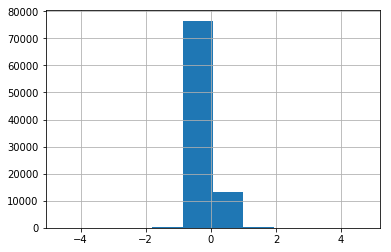

In [85]:
reduced_df.logerror.hist()

Target looks a bit like a Laplace Distribution. We should keep that in mind as we choose ML Algorithms and corresponding loss functions. If we plot the density on a log-scale, the target looks closer to a Normal Distribution.

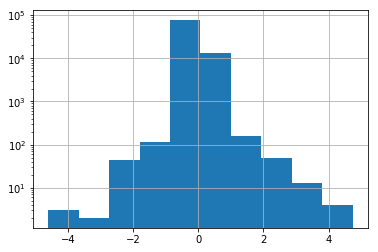

In [87]:
fig, ax = plt.subplots()
reduced_df.logerror.hist(ax=ax)
ax.set_yscale('log')

#### Date column

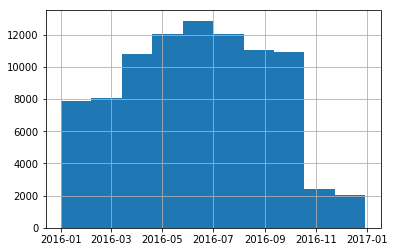

In [81]:
pd.to_datetime(df.transactiondate).hist()

In [82]:
pd.to_datetime(df.transactiondate).min()

Timestamp('2016-01-01 00:00:00')

In [83]:
pd.to_datetime(df.transactiondate).max()

Timestamp('2016-12-30 00:00:00')